In [454]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [455]:
df = pd.read_pickle('base_kmeans.pkl')

In [456]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

def word_tokenization_mba(sentence):
    # tokenize the sentence into individual words
    tokens = word_tokenize(sentence)
    # perform part-of-speech (POS) tagging to identify the grammatical category of each word
    pos_tags = pos_tag(tokens)
    # use regular expressions to identify specific patterns in the sentence
    elements = []
    for word, pos in pos_tags:
        if pos in ('NNP','NN','CD','JJ'):
            elements.append(word)
    return(elements)

In [457]:
df['lst_tokens_desc'] = df['DESCRIPTION_UC'].apply(lambda x: word_tokenization_mba(x))
df_dummies = pd.get_dummies(df['lst_tokens_desc'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, df_dummies], axis=1)

In [458]:
columns_to_remove = ['OPPORT_TYPE',
 'CURRENCY',
 'MEPP_x',
 'OPPORT_TYPE_DESC',
 'GROUPING_LEVEL',
 'LOTE',
 'TOTAL',
 'Grupo',
 'NewFamília',
 'Segmento',
 'Escopo',
 'Tipo',
 'CREATED_AT_DATE',
 'CREATED_AT_TIME',
 'DELIV_DATE',
 'NUMBER_INT',
 'ATTACHMENTS',
 'TZONE',
 'MESSAGES',
 'DESCRIPTION',
 'DOU_PUBL_DATE',
 'SUB_STATUS',
 'OPPORT_NUM',
 'QUANTITY_x',
 'YPFAMITEM',
 'ORDERED_PROD',
 'CHARACTERISTIC',
 'Chave',
 'lst_tokens_desc',
 'OUTLIER_IQR_UL',
 'STATUS',
 'RECURSAL_PERIOD',
 'DIVULG_DATE_YPCON_DATE_H',
 'START_DATE_H',
 'CREATED_AT_DATE_H',
 'END_DATE_H',
 'COMMERCIAL_PROP_OPEN_DATE_H',
 'END_DATE_H_MES',
 'DESCRIPTION_UC',
 'UNIT_TEXT',
 'TAXNUM',
 'SUPPLIER_NAME',
 'MEPP_y',
 'QUANTITY_y',
 'UNIT_VALUE',
 'target'
 ]

In [459]:
df.drop(df[df['TOTAL_VALUE'].isna()].index,inplace=True)
df['OUTLIER'] = ((df['TOTAL_VALUE'] > df['calc_upper_limit']) | (df['TOTAL_VALUE'] < df['calc_lower_limit']))


In [460]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
scaler = RobustScaler()

scaled_values = scaler.fit_transform(df[['TOTAL_VALUE']])
# Assign the scaled values back to the original dataframe
df['TOTAL_VALUE_scaled'] = pd.Series(scaled_values.reshape(-1), index=df.index)

In [461]:
df_orig = df.copy()
df = df.drop(columns_to_remove, axis='columns')

In [462]:
X = df

In [463]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['UNIT'] = le.fit_transform(X['UNIT'])

In [464]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14578 entries, 81965 to 96919
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UNIT                14578 non-null  int32  
 1   TOTAL_VALUE         14578 non-null  float64
 2   calc_upper_limit    14463 non-null  float64
 3   calc_lower_limit    14463 non-null  float64
 4   171                 14578 non-null  uint8  
 5   A                   14578 non-null  uint8  
 6   AR                  14578 non-null  uint8  
 7   ASME                14578 non-null  uint8  
 8   BAGNOLO             14578 non-null  uint8  
 9   BHT                 14578 non-null  uint8  
 10  BREMBANA            14578 non-null  uint8  
 11  BROWN               14578 non-null  uint8  
 12  C70600              14578 non-null  uint8  
 13  CASCO               14578 non-null  uint8  
 14  CBC                 14578 non-null  uint8  
 15  CHEMICA             14578 non-null  uint8  
 16  

In [465]:
X['UNIT'].unique()

array([1, 0])

In [466]:
cols = X.columns

#from sklearn.preprocessing import MinMaxScaler
#ms = MinMaxScaler()
#X = ms.fit_transform(X)

#OU#

from sklearn.decomposition import PCA
pca = PCA(2)
X = pca.fit_transform(X)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#X = pd.DataFrame(X, columns=[cols])
#X
#X.shape

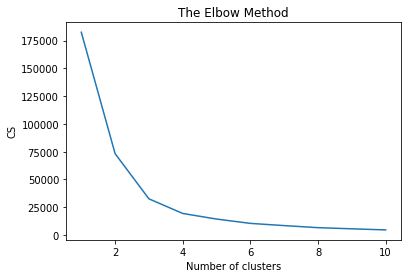

In [ ]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.9697310007492566
For n_clusters = 3 The average silhouette_score is : 0.848166960441729
For n_clusters = 4 The average silhouette_score is : 0.7460988363225388
For n_clusters = 5 The average silhouette_score is : 0.6996841542905948
For n_clusters = 6 The average silhouette_score is : 0.6060779235478777
For n_clusters = 7 The average silhouette_score is : 0.5558961618446544
For n_clusters = 8 The average silhouette_score is : 0.5780288593262997
For n_clusters = 9 The average silhouette_score is : 0.5779579384808077
For n_clusters = 10 The average silhouette_score is : 0.5456957474735916


In [ ]:
import numpy as np
from scipy import stats

def gap_statistic(X, max_k):
    """
    Implements the Gap Statistic method to determine the optimal number of clusters for K-means clustering.
    
    Args:
        X: array-like or sparse matrix, shape (n_samples, n_features)
            The input data.
        max_k: int
            The maximum number of clusters to consider.
            
    Returns:
        gaps: list of gap statistics for each k value from 1 to max_k.
    """
    
    # Calculate the observed gap statistic for each k
    gaps = []
    for k in range(1, max_k+1):
        # Fit KMeans model for current k
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        
        # Calculate sum of within-cluster squared distances
        Wk = kmeans.inertia_
        
        # Generate reference data for null distribution
        B = 10  # Number of reference datasets to generate
        ref_Wk = np.zeros(B)
        for i in range(B):
            # Generate random data with same distribution as X
            X_sim = np.random.uniform(low=X.min(), high=X.max(), size=X.shape)
            
            # Fit KMeans model for current k on random data
            kmeans_sim = KMeans(n_clusters=k)
            kmeans_sim.fit(X_sim)
            
            # Calculate sum of within-cluster squared distances for simulated data
            ref_Wk[i] = kmeans_sim.inertia_
        
        # Calculate expected gap statistic and its standard deviation
        E_Wk = np.mean(ref_Wk)
        sd_Wk = np.sqrt(np.var(ref_Wk) * (1 + 1/B))
        
        # Calculate gap statistic
        gap = np.log(E_Wk) - np.log(Wk)
        
        # Adjust for reference distribution and add to list of gaps
        gap_adjusted = gap - (np.log(stats.norm.cdf(sd_Wk)) / B)
        gaps.append(gap_adjusted)
        
    return gaps

# Call gap_statistic function to determine optimal number of clusters
max_k = 10
gaps = gap_statistic(X, max_k)

# Find optimal number of clusters
optimal_k = np.argmax(gaps) + 1
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 10


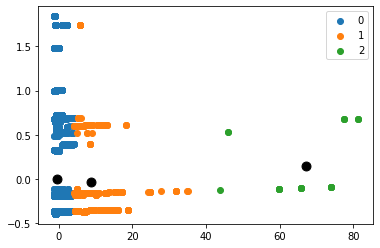

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit_predict(X)
labels = kmeans.labels_

#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[labels == i , 0] , X[labels == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

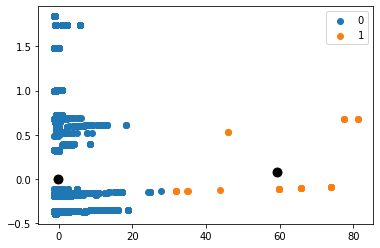

In [ ]:
#df_orig[df_orig.TOTAL_VALUE.isna()]

In [ ]:
df_orig['labels'] = labels
df_orig.to_excel('kmeans.xlsx')